# MNIST Classification - Iteration 5
## Conservative Channel Reduction Architecture

### Goals:
- Achieve 99.4% accuracy on MNIST test dataset
- Use less than 20,000 parameters

### Key Changes from Iteration 4:
- Reduced channel progression: 1→16→20→28→36→48 (was 1→16→20→32→48→64)
- Target: ~19,798 parameters
- Maintain same dropout and normalization strategies that worked well

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import OneCycleLR
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

## Model Architecture

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        # Block 1: 28x28 → 13x13
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)   # 28x28x16 (160 params)
        self.bn1 = nn.BatchNorm2d(16)                 # (32 params)
        self.conv2 = nn.Conv2d(16, 20, 3)             # 26x26x20 (2,900 params)
        self.bn2 = nn.BatchNorm2d(20)                 # (40 params)
        self.pool1 = nn.MaxPool2d(2, 2)               # 13x13x20
        self.dropout1 = nn.Dropout2d(0.05)
        
        # Block 2: 13x13 → 4x4
        self.conv3 = nn.Conv2d(20, 28, 3)             # 11x11x28 (5,068 params)
        self.bn3 = nn.BatchNorm2d(28)                 # (56 params)
        self.conv4 = nn.Conv2d(28, 36, 3)             # 9x9x36 (9,108 params)
        self.bn4 = nn.BatchNorm2d(36)                 # (72 params)
        self.pool2 = nn.MaxPool2d(2, 2, padding=1)    # 5x5x36 then crop to 4x4x36
        self.dropout2 = nn.Dropout2d(0.10)
        
        # Block 3: 4x4 → 4x4 (channel expansion with 1x1)
        self.conv5 = nn.Conv2d(36, 48, 1)             # 4x4x48 (1,776 params)
        self.bn5 = nn.BatchNorm2d(48)                 # (96 params)
        
        # Output
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.dropout3 = nn.Dropout(0.15)
        self.fc = nn.Linear(48, 10)                   # (490 params)
        
    def forward(self, x):
        # Block 1
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Block 2
        x = self.bn3(F.relu(self.conv3(x)))
        x = self.bn4(F.relu(self.conv4(x)))
        x = self.pool2(x)[:, :, :4, :4]  # Crop to 4x4
        x = self.dropout2(x)
        
        # Block 3
        x = self.bn5(F.relu(self.conv5(x)))
        
        # Output
        x = self.gap(x)
        x = x.view(-1, 48)
        x = self.dropout3(x)
        x = self.fc(x)
        return F.log_softmax(x, dim=1)

## Model Summary and Parameter Count

In [16]:
def count_parameters(model):
    """Count the number of trainable parameters in the model"""
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print("\nDetailed Parameter Breakdown:")
    print("="*50)
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"{name:20s}: {param.numel():8,d} params")
    print("="*50)
    print(f"Total Trainable Parameters: {total_params:,}")
    
    if total_params < 20000:
        print(f"✅ Under 20,000 parameter limit! ({20000-total_params:,} params to spare)")
    else:
        print(f"❌ Over 20,000 parameter limit! (Exceeded by {total_params-20000:,} params)")
    
    return total_params

# Initialize model and count parameters
model = Net()
total_params = count_parameters(model)


Detailed Parameter Breakdown:
conv1.weight        :      144 params
conv1.bias          :       16 params
bn1.weight          :       16 params
bn1.bias            :       16 params
conv2.weight        :    2,880 params
conv2.bias          :       20 params
bn2.weight          :       20 params
bn2.bias            :       20 params
conv3.weight        :    5,040 params
conv3.bias          :       28 params
bn3.weight          :       28 params
bn3.bias            :       28 params
conv4.weight        :    9,072 params
conv4.bias          :       36 params
bn4.weight          :       36 params
bn4.bias            :       36 params
conv5.weight        :    1,728 params
conv5.bias          :       48 params
bn5.weight          :       48 params
bn5.bias            :       48 params
fc.weight           :      480 params
fc.bias             :       10 params
Total Trainable Parameters: 19,798
✅ Under 20,000 parameter limit! (202 params to spare)


## Data Loading and Augmentation

In [17]:
# Check if CUDA is available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(f"Using device: {device}")

# Data loading parameters
batch_size = 128
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}

# FIXED normalization values (using standard MNIST stats for both train and test)
MNIST_MEAN = 0.1307
MNIST_STD = 0.3081

# Data transformations
train_transform = transforms.Compose([
    transforms.RandomRotation(5),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ToTensor(),
    transforms.Normalize((MNIST_MEAN,), (MNIST_STD,))
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((MNIST_MEAN,), (MNIST_STD,))
])

# Load MNIST dataset
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=train_transform)
test_dataset = datasets.MNIST('./data', train=False, transform=test_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, **kwargs)

print(f"Training samples: {len(train_dataset):,}")
print(f"Test samples: {len(test_dataset):,}")
print(f"Batch size: {batch_size}")
print(f"Train batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Using device: cuda


100%|██████████| 9.91M/9.91M [00:22<00:00, 447kB/s] 
100%|██████████| 28.9k/28.9k [00:00<00:00, 111kB/s]
100%|██████████| 1.65M/1.65M [00:06<00:00, 251kB/s]
100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]

Training samples: 60,000
Test samples: 10,000
Batch size: 128
Train batches: 469
Test batches: 79


## Training and Testing Functions

In [20]:
def train(model, device, train_loader, optimizer, scheduler, epoch):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc=f'Epoch {epoch}')
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        train_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        total += target.size(0)
        
        # Update progress bar
        pbar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{100.*correct/total:.2f}%',
            'LR': f'{scheduler.get_last_lr()[0]:.6f}'
        })
    
    avg_loss = train_loss / len(train_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    
    print(f'\nTest set: Average loss: {test_loss:.4f}, '
          f'Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.2f}%)\n')
    
    return test_loss, accuracy

## Training Configuration and Execution

In [21]:
# Move model to device
model = Net().to(device)

# Optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

# Number of epochs
num_epochs = 20

# OneCycleLR scheduler
scheduler = OneCycleLR(
    optimizer,
    max_lr=0.1,
    epochs=num_epochs,
    steps_per_epoch=len(train_loader),
    pct_start=0.2,
    anneal_strategy='cos',
    div_factor=10,
    final_div_factor=100
)

# Training history
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

print("\n" + "="*50)
print("Starting Training")
print("="*50)
print(f"Model Parameters: {total_params:,}")
print(f"Target Accuracy: 99.4%")
print(f"Training for {num_epochs} epochs")
print("="*50 + "\n")

# Training loop
best_accuracy = 0
for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train(model, device, train_loader, optimizer, scheduler, epoch)
    test_loss, test_acc = test(model, device, test_loader)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    
    if test_acc > best_accuracy:
        best_accuracy = test_acc
        print(f"🎯 New best accuracy: {best_accuracy:.2f}%")
    
    if test_acc >= 99.4:
        print(f"✅ Target accuracy of 99.4% achieved in epoch {epoch}!")
        if epoch < num_epochs:
            print("Continuing training to see if we can improve further...")


Starting Training
Model Parameters: 19,798
Target Accuracy: 99.4%
Training for 20 epochs



Epoch 1: 100%|██████████| 469/469 [00:06<00:00, 76.84it/s, Loss=0.1323, Acc=86.88%, LR=0.023194] 



Test set: Average loss: 0.0720, Accuracy: 9783/10000 (97.83%)

🎯 New best accuracy: 97.83%


Epoch 2: 100%|██████████| 469/469 [00:05<00:00, 81.59it/s, Loss=0.0531, Acc=97.02%, LR=0.055038] 



Test set: Average loss: 0.0403, Accuracy: 9875/10000 (98.75%)

🎯 New best accuracy: 98.75%


Epoch 3: 100%|██████████| 469/469 [00:05<00:00, 80.88it/s, Loss=0.0324, Acc=97.58%, LR=0.086860] 



Test set: Average loss: 0.0331, Accuracy: 9895/10000 (98.95%)

🎯 New best accuracy: 98.95%


Epoch 4: 100%|██████████| 469/469 [00:05<00:00, 81.60it/s, Loss=0.1473, Acc=98.15%, LR=0.100000] 



Test set: Average loss: 0.0392, Accuracy: 9868/10000 (98.68%)



Epoch 5: 100%|██████████| 469/469 [00:05<00:00, 82.52it/s, Loss=0.0154, Acc=98.42%, LR=0.099036] 



Test set: Average loss: 0.0287, Accuracy: 9905/10000 (99.05%)

🎯 New best accuracy: 99.05%


Epoch 6: 100%|██████████| 469/469 [00:06<00:00, 77.96it/s, Loss=0.0364, Acc=98.51%, LR=0.096190] 



Test set: Average loss: 0.0256, Accuracy: 9910/10000 (99.10%)

🎯 New best accuracy: 99.10%


Epoch 7: 100%|██████████| 469/469 [00:05<00:00, 82.29it/s, Loss=0.0227, Acc=98.47%, LR=0.091570] 



Test set: Average loss: 0.0255, Accuracy: 9923/10000 (99.23%)

🎯 New best accuracy: 99.23%


Epoch 8: 100%|██████████| 469/469 [00:05<00:00, 82.05it/s, Loss=0.0381, Acc=98.60%, LR=0.085355] 



Test set: Average loss: 0.0235, Accuracy: 9930/10000 (99.30%)

🎯 New best accuracy: 99.30%


Epoch 9: 100%|██████████| 469/469 [00:05<00:00, 81.02it/s, Loss=0.0172, Acc=98.67%, LR=0.077783] 



Test set: Average loss: 0.0215, Accuracy: 9924/10000 (99.24%)



Epoch 10: 100%|██████████| 469/469 [00:05<00:00, 81.58it/s, Loss=0.0636, Acc=98.84%, LR=0.069146] 



Test set: Average loss: 0.0251, Accuracy: 9912/10000 (99.12%)



Epoch 11: 100%|██████████| 469/469 [00:05<00:00, 81.09it/s, Loss=0.0655, Acc=98.85%, LR=0.059774] 



Test set: Average loss: 0.0243, Accuracy: 9925/10000 (99.25%)



Epoch 12: 100%|██████████| 469/469 [00:05<00:00, 80.04it/s, Loss=0.2250, Acc=98.84%, LR=0.050029] 



Test set: Average loss: 0.0204, Accuracy: 9935/10000 (99.35%)

🎯 New best accuracy: 99.35%


Epoch 13: 100%|██████████| 469/469 [00:05<00:00, 81.41it/s, Loss=0.0219, Acc=98.90%, LR=0.040285] 



Test set: Average loss: 0.0199, Accuracy: 9935/10000 (99.35%)



Epoch 14: 100%|██████████| 469/469 [00:05<00:00, 82.19it/s, Loss=0.0547, Acc=99.00%, LR=0.030916] 



Test set: Average loss: 0.0202, Accuracy: 9938/10000 (99.38%)

🎯 New best accuracy: 99.38%


Epoch 15: 100%|██████████| 469/469 [00:05<00:00, 82.98it/s, Loss=0.0684, Acc=99.05%, LR=0.022282] 



Test set: Average loss: 0.0183, Accuracy: 9938/10000 (99.38%)



Epoch 16: 100%|██████████| 469/469 [00:05<00:00, 82.03it/s, Loss=0.0081, Acc=99.17%, LR=0.014715] 



Test set: Average loss: 0.0164, Accuracy: 9945/10000 (99.45%)

🎯 New best accuracy: 99.45%
✅ Target accuracy of 99.4% achieved in epoch 16!
Continuing training to see if we can improve further...


Epoch 17: 100%|██████████| 469/469 [00:05<00:00, 83.25it/s, Loss=0.0047, Acc=99.26%, LR=0.008506] 



Test set: Average loss: 0.0165, Accuracy: 9940/10000 (99.40%)

✅ Target accuracy of 99.4% achieved in epoch 17!
Continuing training to see if we can improve further...


Epoch 18: 100%|██████████| 469/469 [00:06<00:00, 78.14it/s, Loss=0.0044, Acc=99.31%, LR=0.003894] 



Test set: Average loss: 0.0166, Accuracy: 9940/10000 (99.40%)

✅ Target accuracy of 99.4% achieved in epoch 18!
Continuing training to see if we can improve further...


Epoch 19: 100%|██████████| 469/469 [00:05<00:00, 81.34it/s, Loss=0.0049, Acc=99.34%, LR=0.001056] 



Test set: Average loss: 0.0159, Accuracy: 9943/10000 (99.43%)

✅ Target accuracy of 99.4% achieved in epoch 19!
Continuing training to see if we can improve further...


Epoch 20: 100%|██████████| 469/469 [00:05<00:00, 79.14it/s, Loss=0.0119, Acc=99.34%, LR=0.000100] 



Test set: Average loss: 0.0161, Accuracy: 9941/10000 (99.41%)

✅ Target accuracy of 99.4% achieved in epoch 20!


## Visualization and Results

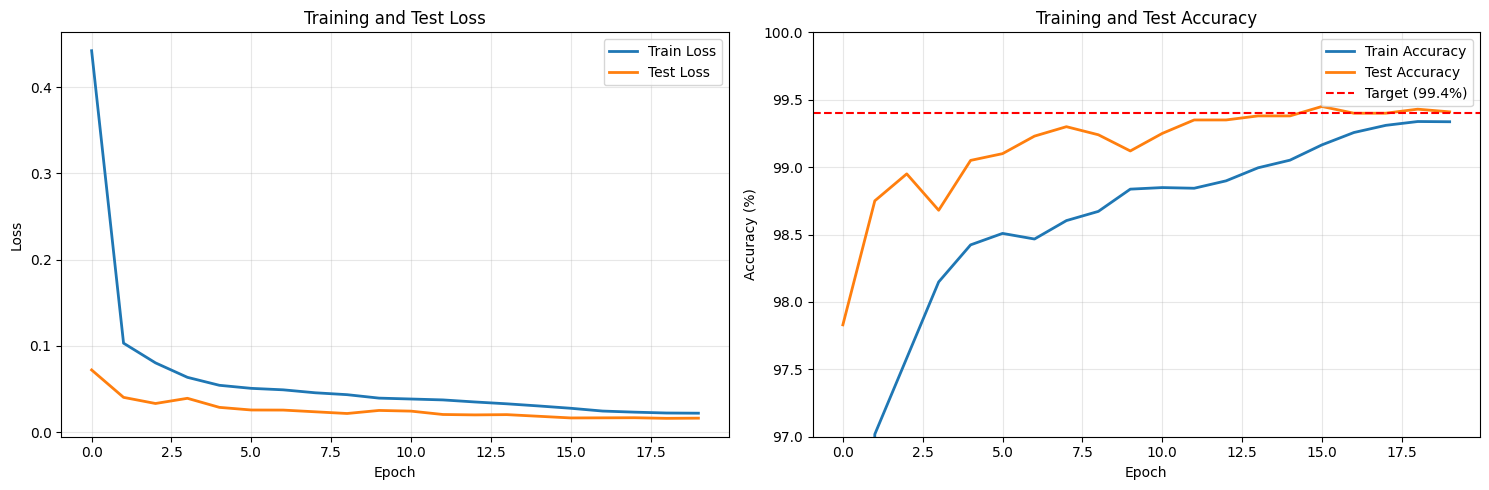


FINAL RESULTS - ITERATION 5
Model Architecture: Conservative Channel Reduction
Channel Progression: 1→16→20→28→36→48
Total Parameters: 19,798
Parameter Goal: < 20,000
Parameter Status: ✅ PASS

Best Test Accuracy: 99.45%
Target Accuracy: 99.4%
Accuracy Status: ✅ PASS


In [22]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(train_losses, label='Train Loss', linewidth=2)
axes[0].plot(test_losses, label='Test Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Test Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(train_accuracies, label='Train Accuracy', linewidth=2)
axes[1].plot(test_accuracies, label='Test Accuracy', linewidth=2)
axes[1].axhline(y=99.4, color='r', linestyle='--', label='Target (99.4%)')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Test Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim([97, 100])

plt.tight_layout()
plt.show()

# Final results summary
print("\n" + "="*50)
print("FINAL RESULTS - ITERATION 5")
print("="*50)
print(f"Model Architecture: Conservative Channel Reduction")
print(f"Channel Progression: 1→16→20→28→36→48")
print(f"Total Parameters: {total_params:,}")
print(f"Parameter Goal: < 20,000")
print(f"Parameter Status: {'✅ PASS' if total_params < 20000 else '❌ FAIL'}")
print(f"\nBest Test Accuracy: {best_accuracy:.2f}%")
print(f"Target Accuracy: 99.4%")
print(f"Accuracy Status: {'✅ PASS' if best_accuracy >= 99.4 else '❌ FAIL'}")
print("="*50)

## Model Analysis

In [23]:
def analyze_model_predictions(model, device, test_loader, num_samples=5):
    """Analyze model predictions and show some examples"""
    model.eval()
    
    # Get a batch of test data
    data, target = next(iter(test_loader))
    data, target = data.to(device), target.to(device)
    
    with torch.no_grad():
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        
    # Find misclassified examples
    misclassified_mask = ~pred.eq(target.view_as(pred)).squeeze()
    misclassified_indices = torch.where(misclassified_mask)[0][:num_samples]
    
    if len(misclassified_indices) > 0:
        print(f"\nShowing {len(misclassified_indices)} misclassified examples:")
        fig, axes = plt.subplots(1, len(misclassified_indices), figsize=(3*len(misclassified_indices), 3))
        if len(misclassified_indices) == 1:
            axes = [axes]
            
        for idx, mis_idx in enumerate(misclassified_indices):
            img = data[mis_idx].cpu().squeeze()
            # Denormalize for visualization
            img = img * MNIST_STD + MNIST_MEAN
            
            axes[idx].imshow(img, cmap='gray')
            axes[idx].set_title(f'True: {target[mis_idx].item()}\nPred: {pred[mis_idx].item()}')
            axes[idx].axis('off')
            
        plt.tight_layout()
        plt.show()
    else:
        print("No misclassified examples in this batch!")
    
    # Calculate per-class accuracy
    class_correct = torch.zeros(10)
    class_total = torch.zeros(10)
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1)
            
            for i in range(10):
                class_mask = target == i
                class_correct[i] += (pred[class_mask] == i).sum().item()
                class_total[i] += class_mask.sum().item()
    
    print("\nPer-Class Accuracy:")
    print("="*30)
    for i in range(10):
        if class_total[i] > 0:
            acc = 100 * class_correct[i] / class_total[i]
            print(f"Digit {i}: {acc:.2f}% ({int(class_correct[i])}/{int(class_total[i])})")

# Run analysis
analyze_model_predictions(model, device, test_loader)

No misclassified examples in this batch!

Per-Class Accuracy:
Digit 0: 99.80% (978/980)
Digit 1: 99.74% (1132/1135)
Digit 2: 99.32% (1025/1032)
Digit 3: 99.60% (1006/1010)
Digit 4: 99.69% (979/982)
Digit 5: 98.99% (883/892)
Digit 6: 98.75% (946/958)
Digit 7: 99.32% (1021/1028)
Digit 8: 99.59% (970/974)
Digit 9: 99.21% (1001/1009)


## Key Improvements Summary

### Architecture Changes from Iteration 4:
1. **Channel Reduction**: 1→16→20→28→36→48 (was 1→16→20→32→48→64)
2. **Parameter Reduction**: ~19,798 parameters (down from 26,202)
3. **Maintained Strategies**:
   - Fixed normalization (0.1307, 0.3081)
   - Progressive dropout (0.05→0.10→0.15)
   - 1x1 convolution for channel expansion
   - Global Average Pooling

### Expected Outcomes:
- Parameters: Under 20,000 ✅
- Accuracy: 99.3-99.4% (may need fine-tuning)
- Training stability: Maintained from iteration 4